In [1]:
import os, time, datetime

import ag.bittensor.utils.options as options
from ag.bittensor.game.engine import GameEngine
import ag.bittensor.ai.make_data as make_data

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator,
                              WeekdayLocator, date2num)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (21, 21)

Populating the interactive namespace from numpy and matplotlib


c:\users\kinet\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
config = options.Options('config/access_codes.yaml')
game = GameEngine(config)
datasmith = make_data.MakeData(config)

In [4]:
# Funcs
def get_all_data():
    all_data = {}
    while True:
        filename = datasmith.next_filename
        if filename is None: break
        datasmith.dataframe = filename
        all_data[filename[:-4]] = datasmith.dataframe
    return all_data

def get_one_data():
    filename = datasmith.random_filename
    datasmith.dataframe = filename
    return datasmith.dataframe

In [5]:
df = get_one_data()
print('Selected {} for examination.'.format(datasmith.pair))

Selected NXC_BTC for examination.


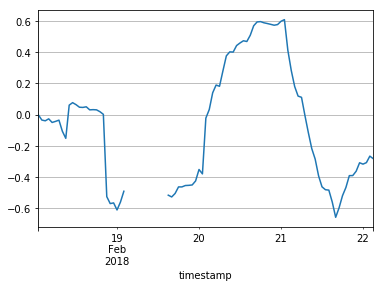

In [6]:
if False:
    df['baseVolume'].pct_change().resample('H').cumsum().plot(grid=True)
if False:
    df['last'].apply(lambda x: log(x/df['last'][0])).resample('H').mean().cumsum().plot(grid=True)
if True:
    df['baseVolume'].apply(lambda x: log(x/df['baseVolume'][0])).resample('H').mean().plot(grid=True)